100%|██████████| 331M/331M [00:02<00:00, 148MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/yousefmohamed20/oxford-102-flower-dataset/versions/1


Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 185MB/s]


Epoch 1, Loss: 139.1970, Train Acc: 9.71%
Validation Accuracy: 47.65%
Epoch 2, Loss: 74.1249, Train Acc: 62.65%
Validation Accuracy: 67.25%
Epoch 3, Loss: 28.0745, Train Acc: 83.53%
Validation Accuracy: 78.24%
Epoch 4, Loss: 12.8087, Train Acc: 92.45%
Validation Accuracy: 80.69%
Epoch 5, Loss: 7.8685, Train Acc: 95.29%
Validation Accuracy: 82.25%
Epoch 6, Loss: 5.2583, Train Acc: 97.65%
Validation Accuracy: 81.76%
Epoch 7, Loss: 3.3145, Train Acc: 98.53%
Validation Accuracy: 81.96%
Epoch 8, Loss: 2.6077, Train Acc: 99.02%
Validation Accuracy: 85.00%
Epoch 9, Loss: 1.8589, Train Acc: 99.12%
Validation Accuracy: 85.98%
Epoch 10, Loss: 1.5777, Train Acc: 99.51%
Validation Accuracy: 85.88%
Epoch 11, Loss: 1.4501, Train Acc: 99.51%
Validation Accuracy: 85.69%
Epoch 12, Loss: 1.2810, Train Acc: 99.61%
Validation Accuracy: 86.37%
Epoch 13, Loss: 0.9663, Train Acc: 99.71%
Validation Accuracy: 87.16%
Epoch 14, Loss: 0.9040, Train Acc: 99.80%
Validation Accuracy: 86.86%
Epoch 15, Loss: 0.7111, T

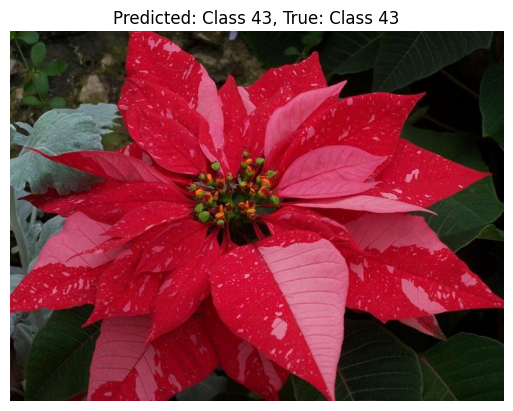

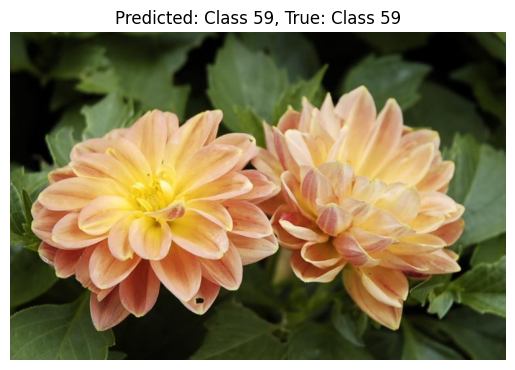

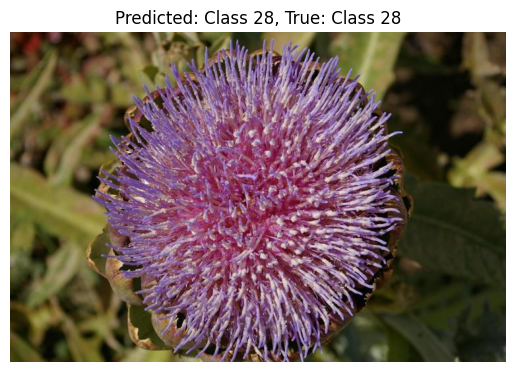

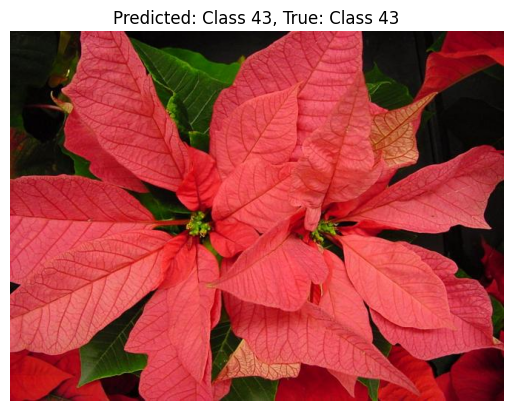

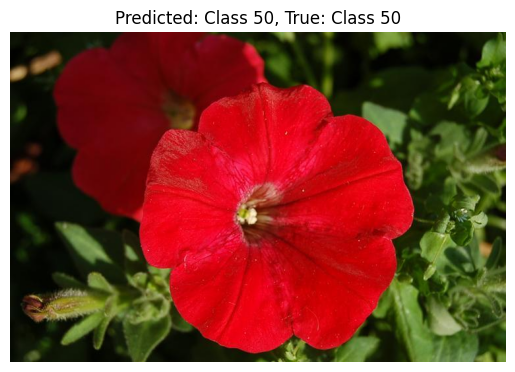

In [ ]:
import os
import numpy as np
import scipy.io
from PIL import Image
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import torchvision.models as models
from torch.optim.lr_scheduler import CosineAnnealingLR
import matplotlib.pyplot as plt
import random
import kagglehub

# Download latest version
path = kagglehub.dataset_download("yousefmohamed20/oxford-102-flower-dataset")

print("Path to dataset files:", path)



device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Load dataset
base_dir = '/content/drive/MyDrive/flowerss'
labels = scipy.io.loadmat(os.path.join(base_dir, 'imagelabels.mat'))['labels'][0]
setid = scipy.io.loadmat(os.path.join(base_dir, 'setid.mat'))
train_ids = setid['trnid'][0]
val_ids = setid['valid'][0]
test_ids = setid['tstid'][0]

def get_image_label_pairs(indices, base_dir, labels):
    image_dir = os.path.join(base_dir, 'flower')
    pairs = []
    for idx in indices:
        path = os.path.join(image_dir, f'image_{idx:05d}.jpg')
        if os.path.exists(path):
            pairs.append((path, labels[idx - 1] - 1))
    return pairs

train_pairs = get_image_label_pairs(train_ids, base_dir, labels)
val_pairs = get_image_label_pairs(val_ids, base_dir, labels)
test_pairs = get_image_label_pairs(test_ids, base_dir, labels)

class FlowerDataset(Dataset):
    def __init__(self, image_label_pairs, transform=None):
        self.image_label_pairs = image_label_pairs
        self.transform = transform

    def __len__(self):
        return len(self.image_label_pairs)

    def __getitem__(self, idx):
        img_path, label = self.image_label_pairs[idx]
        image = Image.open(img_path).convert('RGB')
        if self.transform:
            image = self.transform(image)
        return image, label

train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(20),
    transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),
    transforms.ColorJitter(0.3, 0.3, 0.3, 0.1),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])
val_test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

train_loader = DataLoader(FlowerDataset(train_pairs, train_transform), batch_size=32, shuffle=True, num_workers=2)
val_loader = DataLoader(FlowerDataset(val_pairs, val_test_transform), batch_size=32, shuffle=False, num_workers=2)
test_loader = DataLoader(FlowerDataset(test_pairs, val_test_transform), batch_size=32, shuffle=False, num_workers=2)

# Model setup
model = models.resnet50(weights='IMAGENET1K_V2').to(device)
for param in model.parameters(): param.requires_grad = False
for param in model.layer4.parameters(): param.requires_grad = True
for param in model.fc.parameters(): param.requires_grad = True
model.fc = nn.Linear(model.fc.in_features, 102).to(device)

optimizer = torch.optim.AdamW([
    {'params': model.layer4.parameters(), 'lr': 1e-4},
    {'params': model.fc.parameters(), 'lr': 1e-3}
], weight_decay=1e-4)
criterion = nn.CrossEntropyLoss()
scheduler = CosineAnnealingLR(optimizer, T_max=30, eta_min=1e-6)

# Train
best_val_acc = 0
patience_counter = 0
best_model_path = '/content/drive/MyDrive/saved_models/flower_classifier_best.pth'

def train_model(model, train_loader, val_loader, epochs=30):
    global best_val_acc, patience_counter
    for epoch in range(epochs):
        model.train()
        total, correct, loss_sum = 0, 0, 0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            _, predicted = outputs.max(1)
            correct += predicted.eq(labels).sum().item()
            total += labels.size(0)
            loss_sum += loss.item()
        print(f'Epoch {epoch+1}, Loss: {loss_sum:.4f}, Train Acc: {100 * correct / total:.2f}%')

        model.eval()
        correct, total = 0, 0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                _, predicted = outputs.max(1)
                correct += predicted.eq(labels).sum().item()
                total += labels.size(0)
        val_acc = 100 * correct / total
        print(f'Validation Accuracy: {val_acc:.2f}%')

        if val_acc > best_val_acc:
            best_val_acc = val_acc
            torch.save(model.state_dict(), best_model_path)
            patience_counter = 0
        else:
            patience_counter += 1
        if patience_counter >= 5:
            print('Early stopping.')
            break
        scheduler.step()

train_model(model, train_loader, val_loader)

# Evaluate
model.load_state_dict(torch.load(best_model_path, map_location=device))
model.eval()
correct, total = 0, 0
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = outputs.max(1)
        correct += predicted.eq(labels).sum().item()
        total += labels.size(0)
print(f'Test Accuracy: {100 * correct / total:.2f}%')

# Visualize predictions
class_names = [f'Class {i}' for i in range(102)]
def predict_image(model, image_path):
    image = Image.open(image_path).convert('RGB')
    input_tensor = val_test_transform(image).unsqueeze(0).to(device)
    with torch.no_grad():
        output = model(input_tensor)
        _, predicted = output.max(1)
    return class_names[predicted.item()], image

sample_images = random.sample(test_pairs, 5)
for img_path, true_label in sample_images:
    pred_label, img = predict_image(model, img_path)
    plt.imshow(img)
    plt.title(f'Predicted: {pred_label}, True: Class {true_label}')
    plt.axis('off')
    plt.show()

# Save model
os.makedirs('/content/drive/MyDrive/saved_models', exist_ok=True)
torch.save(model.state_dict(), '/content/drive/MyDrive/saved_models/flower_classifier_state_dict.pth')
torch.save(model, '/content/drive/MyDrive/saved_models/flower_classifier_full_model.pth')
